## Imports

In [2]:
from AGNCatalogToolbox import main as agn
from colossus.cosmology import cosmology
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dc_stat_think as dcst

## Import data from IDL

In [46]:
from scipy.io import readsav
read_data = readsav('vars_EuclidAGN_90.sav',verbose=True)

data={}
for key, val in read_data.items():
    data[key]=np.copy(val)
    data[key][data[key] == 0.] = np.nan
print(data.keys())

--------------------------------------------------
Date: Thu May  7 16:31:57 2020
User: rcarraro
Host: stellarwind.local
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 8 records of which:
 - 5 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - m_ave [<class 'numpy.ndarray'>]
 - sfr_ave [<class 'numpy.ndarray'>]
 - l_ave [<class 'numpy.ndarray'>]
 - bhsf_ave [<class 'numpy.ndarray'>]
 - redshift [<class 'numpy.ndarray'>]
--------------------------------------------------
dict_keys(['m_ave', 'sfr_ave', 'l_ave', 'bhsf_ave', 'redshift'])


## Set cosmology

In [3]:
# my cosmology
params = {'flat': True, 'H0': 70., 'Om0': 0.3, 'Ob0': 0.0486, 'sigma8':0.8159, 'ns':0.9667}
cosmology.addCosmology('Carraro+20', params)

In [4]:
cosmo = 'Carraro+20'
cosmology = cosmology.setCosmology(cosmo)
volume = 200**3

## Set universe parameters

In [77]:
z = 1.7
reds_dic={0.45:0, 1:1, 1.7:2, 2.7:3}
index=reds_dic.get(z) # needed for IDL data

## Generate universe

In [78]:
gals = pd.DataFrame()
gals['halos'] = agn.generate_semi_analytic_halo_catalogue(volume, [10, 16, 0.1], z, params.get('H0')/100)
gals['stellar_mass'] = agn.halo_mass_to_stellar_mass(gals.halos, z)
gals['black_hole_mass'] = agn.stellar_mass_to_black_hole_mass(gals.stellar_mass, method="Shankar16", scatter="Intrinsic")

Scatter is a thing, valued at 0.11


In [79]:
gals['duty_cycle'] = agn.to_duty_cycle("Schulze", gals.stellar_mass, gals.black_hole_mass, z)

GetCorrectFile: Schulze_1.6.csv
Found Schulze file: ./Data/DutyCycles/Schulze_1.6.csv
[0.07913008 0.10916726 0.0756762  ... 0.30565814 0.30565814 0.30565814]


In [80]:
# Schechter parameters fitting
#redshift = [0.1, 1, 2]
#alpha = [-0.25,1.6,7.14]
#lambd = [0.05, -0.8,-0.5]
#alpha_pars=np.polyfit(redshift,alpha,2)
#lambda_pars=np.polyfit(redshift,lambd,2)
#np.savez('schechter_pars.npz',alpha_pars=alpha_pars,lambda_pars=lambda_pars)

schechter_pars=np.load('schechter_pars.npz')
alpha_pars=schechter_pars['alpha_pars']
lambda_pars=schechter_pars['lambda_pars']

alpha_pol=np.poly1d(alpha_pars)
lambda_pol=np.poly1d(lambda_pars)

alpha_z=alpha_pol(z)
lambda_z=lambda_pol(z)

In [81]:
gals['luminosity'] = agn.black_hole_mass_to_luminosity(gals.black_hole_mass, gals.duty_cycle, gals.stellar_mass, z,"Schechter",
                                        bol_corr='Lusso12_modif', parameter1=lambda_z, parameter2=alpha_z)

In [82]:
gals['nh'] = agn.luminosity_to_nh(gals.luminosity, z)
gals['agn_type'] = agn.nh_to_type(gals.nh)

/Users/Ros/Google_Drive/Valparaiso/LX_SFR_causality/EuclidAGN2/AGNCatalogToolbox/main.py:789: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  type[(nh >= 22) & (nh < 24)] = type2[[(nh >= 22) & (nh < 24)]]


In [83]:
gals['SFR'] = agn.SFR(z,gals.stellar_mass,'Carraro20')
gals.describe()

,halos,stellar_mass,black_hole_mass,duty_cycle,luminosity,nh,agn_type,SFR
count,3.500678e+06,3.500678e+06,3.500678e+06,3.500678e+06,3.500678e+06,3.500678e+06,3.500678e+06,3.500678e+06
mean,1.044862e+01,6.866479e+00,-5.085243e+00,3.054620e-01,3.162843e+01,2.668861e+01,2.801043e+00,-1.871944e+00
std,4.257654e-01,9.415131e-01,3.523511e+00,5.182994e-03,3.529886e+00,2.272977e+00,4.630920e-01,9.585489e-01
min,1.000000e+01,5.413526e+00,-1.365254e+01,6.991051e-02,2.284547e+01,1.000000e+00,1.000000e+00,-3.870134e+00
25%,1.013683e+01,6.172844e+00,-7.680830e+00,3.056581e-01,2.903215e+01,2.509554e+01,3.000000e+00,-2.559002e+00
50%,1.031930e+01,6.588119e+00,-5.920273e+00,3.056581e-01,3.079449e+01,2.707877e+01,3.000000e+00,-2.130234e+00
75%,1.063036e+01,7.286203e+00,-3.218893e+00,3.056581e-01,3.349624e+01,2.853984e+01,3.000000e+00,-1.432090e+00
max,1.412762e+01,1.191351e+01,9.724260e+00,3.056581e-01,4.571523e+01,2.999990e+01,3.000000e+00,2.750834e+00


In [84]:
gals['lx/SFR'] = (gals.luminosity-42)-gals.SFR
grouped_gals = gals[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)

gals_lin=pd.DataFrame()
gals_lin['stellar_mass'] = gals['stellar_mass']
gals_lin['luminosity']= 10**(gals.luminosity-42)
gals_lin[['SFR','lx/SFR']]=10**gals[['SFR','lx/SFR']]
grouped_lin = gals_lin[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals.stellar_mass, np.append(np.arange(5, 11.5, 0.5),12.))).quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)
ggals_lin=grouped_lin[grouped_lin['stellar_mass',0.5] > 9]
grouped_lin.index.rename('mass_range',inplace=True)

### Bootstrapping

In [85]:
func=np.median

gals_highM=gals_lin.copy()[gals_lin.stellar_mass > 9]
grouped_linear = gals_highM[['stellar_mass','luminosity','SFR','lx/SFR']].groupby(pd.cut(gals_highM.stellar_mass, np.append(np.arange(9, 11.5, 0.5),12.)))#.quantile([0.05,0.1585,0.5,0.8415,0.95]).unstack(level=1)
gals_bs=pd.DataFrame()
gals_bs['SFR'] = grouped_linear.SFR.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs['luminosity'] = grouped_linear.luminosity.apply(lambda x: dcst.draw_bs_reps(x, func, size=500))
gals_bs.head()

,SFR,luminosity
stellar_mass,,
"(9.0, 9.5]","[3.0982879115769864, 3.0935137935095343, 3.082...","[0.008825312955999223, 0.008806949229403468, 0..."
"(9.5, 10.0]","[9.707491370325158, 9.766630250260711, 9.73571...","[0.21715517525075861, 0.21766905942921158, 0.2..."
"(10.0, 10.5]","[30.86405513232284, 30.854695211590155, 30.803...","[6.5297274491539055, 6.57935683946639, 6.48767..."
"(10.5, 11.0]","[72.27811231601477, 72.83098515339577, 72.2973...","[59.838456821363145, 60.26885677862869, 59.845..."
"(11.0, 12.0]","[88.3359466345344, 88.06528893133007, 90.35101...","[287.57293551776604, 288.31533002031523, 278.3..."


In [86]:
# create dataframe with percentiles of the bootstrapped distribution
bs_perc=ggals_lin['stellar_mass']
old_idx = bs_perc.columns.to_frame()
perc_colnames=bs_perc.columns
old_idx.insert(0, '', 'stellar_mass')
bs_perc.columns = pd.MultiIndex.from_frame(old_idx)

bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['SFR']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['SFR'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row,[0.05,0.1585,0.5,0.8415,0.95]) for row in gals_bs['luminosity']]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['luminosity'],perc_colnames])))
bs_perc=bs_perc.join(pd.DataFrame(np.array([np.quantile(row['luminosity']/row['SFR'],[0.05,0.1585,0.5,0.8415,0.95]) for i,row in gals_bs.iterrows()]), 
                                  index=bs_perc.index, columns=pd.MultiIndex.from_product([['lx_SFR'],perc_colnames])))
#print(bs_perc)

### Plots

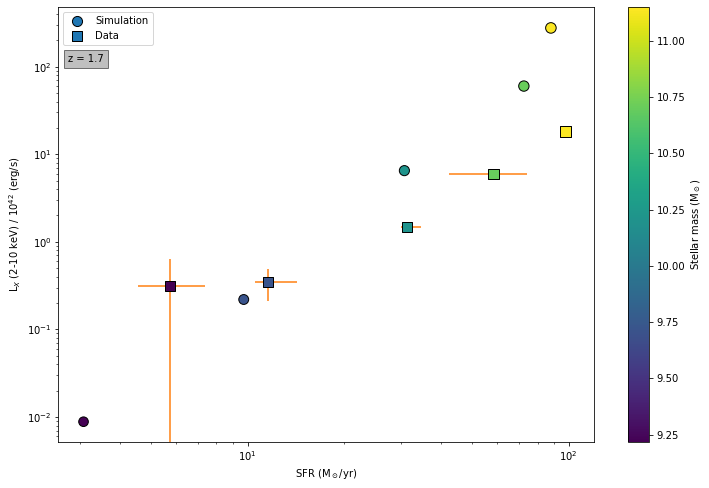

In [87]:
i=index
_min = np.minimum(np.nanmin(bs_perc['stellar_mass',0.5]),np.nanmin(data['m_ave'][0,2:,:]))
_max = np.maximum(np.nanmax(bs_perc['stellar_mass',0.5]),np.nanmax(data['m_ave'][0,2:,:]))

xerr=np.array([bs_perc['SFR',0.5] - bs_perc['SFR',0.05], 
              bs_perc['SFR',0.95] - bs_perc['SFR',0.5]])
yerr=np.array([bs_perc['luminosity',0.5] - bs_perc['luminosity',0.05], 
               bs_perc['luminosity',0.95] - bs_perc['luminosity',0.5]])

fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 8]
plt.scatter(bs_perc['SFR',0.5],bs_perc['luminosity',0.5], vmin = _min, vmax = _max, edgecolors='Black',
            c=bs_perc['stellar_mass',0.5] , s=bs_perc['stellar_mass',0.5]*10, label='Simulation')
plt.errorbar(bs_perc['SFR',0.5],bs_perc['luminosity',0.5],
                xerr=xerr, yerr=yerr, linestyle='', zorder=0);

sc=plt.scatter(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i], vmin = _min, vmax = _max, edgecolors='Black',
            c=data['m_ave'][0,2:,0], s=data['m_ave'][0,2:,0]*10, marker="s",label='Data')
plt.errorbar(data['sfr_ave'][0,2:,i], data['l_ave'][0,2:,i],
                xerr=[data['sfr_ave'][0,2:,i]-data['sfr_ave'][2,2:,i],
                    data['sfr_ave'][1,2:,i]-data['sfr_ave'][0,2:,i]],
                yerr=np.array([data['l_ave'][0,2:,i] - data['l_ave'][2,2:,i], 
                    data['l_ave'][1,2:,i] - data['l_ave'][0,2:,i]]),
                linestyle='', zorder=0);

plt.colorbar(sc).set_label('Stellar mass (M$_\odot$)')
plt.text(0.157, 0.79, f'z = {z:.1f}', horizontalalignment='center',
          verticalalignment='center', bbox=dict(facecolor='gray', alpha=0.5), transform=fig.transFigure)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('SFR (M$_\odot$/yr)')
plt.ylabel('L$_X$ (2-10 keV) / $10^{42}$ (erg/s)')
plt.legend(loc='upper left');
curr_dir=os.getcwd()
plt.savefig(curr_dir+f'/Ros_plots/SFvsLX_z{z}.pdf', format = 'pdf', bbox_inches = 'tight',transparent=True) 